2025-01-23 15:10:46,297 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
Slowest decaying mode: λ = (-0.0725274157945158-0.8985611581581723j)


/tmp/ipykernel_603/1772494700.py:96: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0,0].pcolormesh(x, y, u['g'][0].real, cmap=cmap)
/tmp/ipykernel_603/1772494700.py:98: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0,1].pcolormesh(x, y, u['g'][1].real, cmap=cmap)
/tmp/ipykernel_603/1772494700.py:100: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1,0].pcolormesh(x, y, w['

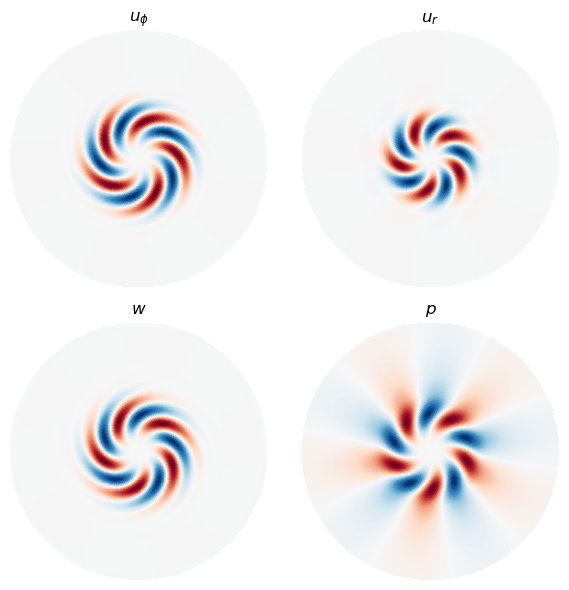

In [1]:
"""
Dedalus script solving the linear stability eigenvalue problem for pipe flow.
This script demonstrates solving an eigenvalue problem in the periodic cylinder
using the disk basis and a parametrized axial wavenumber. It should take just
a few seconds to run (serial only).

The radius of the pipe is R = 1, and the problem is non-dimensionalized using
the radius and laminar velocity, such that the background flow is w0 = 1 - r**2.

No-slip boundary conditions are implemented on the velocity perturbations.
For incompressible hydro with one boundary, we need one tau term each for the
scalar axial velocity and vector horizontal (in-disk) velocity. Here we choose
to left the tau terms to the original (k=0) basis.

The eigenvalues are compared to the results of Vasil et al. (2016) [1] in Table 3.

To run, print, and plot the slowest decaying mode:
    $ python3 pipe_flow.py

References:
    [1]: G. M. Vasil, K. J. Burns, D. Lecoanet, S. Olver, B. P. Brown, J. S. Oishi,
         "Tensor calculus in polar coordinates using Jacobi polynomials," Journal
         of Computational Physics (2016).
"""


import numpy as np
import dedalus.public as d3
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)


# Parameters
Re = 1e4
kz = 1
m = 5
Nphi = 2 * m + 2
Nr = 64
dtype = np.complex128

# Bases
coords = d3.PolarCoordinates('phi', 'r')
dist = d3.Distributor(coords, dtype=dtype)
disk = d3.DiskBasis(coords, shape=(Nphi, Nr), radius=1, dtype=dtype)
phi, r = dist.local_grids(disk)

# Fields
s = dist.Field(name='s')
u = dist.VectorField(coords, name='u', bases=disk)
w = dist.Field(name='w', bases=disk)
p = dist.Field(name='p', bases=disk)
tau_u = dist.VectorField(coords, name='tau_u', bases=disk.edge)
tau_w = dist.Field(name='tau_w', bases=disk.edge)
tau_p = dist.Field(name='tau_p')

# Substitutions
dt = lambda A: s*A
dz = lambda A: 1j*kz*A
lift_basis = disk.derivative_basis(2)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Background
w0 = dist.Field(name='w0', bases=disk.radial_basis)
w0['g'] = 1 - r**2

# Problem
problem = d3.EVP([u, w, p, tau_u, tau_w, tau_p], eigenvalue=s, namespace=locals())
problem.add_equation("div(u) + dz(w) = 0")
problem.add_equation("dt(u) + w0*dz(u) + grad(p) - (1/Re)*(lap(u)+dz(dz(u))) + lift(tau_u) = 0")
problem.add_equation("dt(w) + w0*dz(w) + u@grad(w0) + dz(p) - (1/Re)*(lap(w)+dz(dz(w))) + lift(tau_w) = 0")
problem.add_equation("u(r=1) = 0")
problem.add_equation("w(r=1) = 0")

# Solver
solver = problem.build_solver()
sp = solver.subproblems_by_group[(m, None)]
solver.solve_dense(sp)
evals = solver.eigenvalues[np.isfinite(solver.eigenvalues)]
evals = evals[np.argsort(-evals.real)]
print(f"Slowest decaying mode: λ = {evals[0]}")
solver.set_state(np.argmin(np.abs(solver.eigenvalues - evals[0])), sp.subsystems[0])

# Plot eigenfunction
scales = (32, 4)
ω = d3.div(d3.skew(u)).evaluate()
ω.change_scales(scales)
u.change_scales(scales)
w.change_scales(scales)
p.change_scales(scales)
phi, r = dist.local_grids(disk, scales=scales)
x, y = coords.cartesian(phi, r)

cmap = 'RdBu_r'
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0,0].pcolormesh(x, y, u['g'][0].real, cmap=cmap)
ax[0,0].set_title(r"$u_\phi$")
ax[0,1].pcolormesh(x, y, u['g'][1].real, cmap=cmap)
ax[0,1].set_title(r"$u_r$")
ax[1,0].pcolormesh(x, y, w['g'].real, cmap=cmap)
ax[1,0].set_title(r"$w$")
ax[1,1].pcolormesh(x, y, p['g'].real, cmap=cmap)
ax[1,1].set_title(r"$p$")
for axi in ax.flatten():
    axi.set_aspect('equal')
    axi.set_axis_off()
fig.tight_layout()
fig.savefig("pipe_eigenfunctions.png", dpi=200)
